In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
# Install Required Libraries
!pip install transformers scikit-learn pandas torch peft

In [13]:
import pandas as pd
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from peft import LoraConfig, get_peft_model

# Load LLM

In [14]:
# Load BioBERT
model_name = "dmis-lab/biobert-base-cased-v1.1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=59)  # Placeholder for `num_labels`

# GPU Check
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Load File

In [15]:
# Load Pre-split Datasets
train_path = "/content/drive/MyDrive/P2/T1/Dataset/combined/LLM-c-train.csv"
val_path = "/content/drive/MyDrive/P2/T1/Dataset/combined/LLM-c-val.csv"
test_path = "/content/drive/MyDrive/P2/T1/Dataset/combined/LLM-c-test.csv"

train_data = pd.read_csv(train_path)
val_data = pd.read_csv(val_path)
test_data = pd.read_csv(test_path)

In [16]:
# Encode Disease Labels
label_encoder = LabelEncoder()
train_data['encoded_labels'] = label_encoder.fit_transform(train_data['disease_label'])
val_data['encoded_labels'] = label_encoder.transform(val_data['disease_label'])
test_data['encoded_labels'] = label_encoder.transform(test_data['disease_label'])

num_classes = len(label_encoder.classes_)

# Update BioBERT Model for Classification
model.num_labels = num_classes  # Update number of labels

# Tokenize Symptoms

In [17]:
# Tokenize Symptoms
def tokenize_texts(texts):
    return tokenizer(texts.tolist(), padding=True, truncation=True, max_length=128, return_tensors="pt")

train_encodings = tokenize_texts(train_data['symptoms'])
val_encodings = tokenize_texts(val_data['symptoms'])
test_encodings = tokenize_texts(test_data['symptoms'])

# Convert labels to tensors
train_labels = torch.tensor(train_data['encoded_labels'].tolist())
val_labels = torch.tensor(val_data['encoded_labels'].tolist())
test_labels = torch.tensor(test_data['encoded_labels'].tolist())

# Dataset Class for Fine-Tuning
class SymptomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

# Create PyTorch Datasets
train_dataset = SymptomDataset(train_encodings, train_labels)
val_dataset = SymptomDataset(val_encodings, val_labels)


# Fine-tuning BioBERT with LoRA

In [18]:
# Lastest found: No LoRA, performance is better
"""
# Configure LoRA for BioBERT
lora_config = LoraConfig(
    r=8,  # Low-rank adaptation rank
    lora_alpha=32,  # Scaling factor
    target_modules=["query", "value"],  # LoRA applied to attention layers
    lora_dropout=0.1,  # Dropout rate for regularization
    task_type="SEQ_CLS"  # Sequence classification task
)

model = get_peft_model(model, lora_config)
print("LoRA applied successfully to BioBERT!")
"""

'\n# Configure LoRA for BioBERT\nlora_config = LoraConfig(\n    r=8,  # Low-rank adaptation rank\n    lora_alpha=32,  # Scaling factor\n    target_modules=["query", "value"],  # LoRA applied to attention layers\n    lora_dropout=0.1,  # Dropout rate for regularization\n    task_type="SEQ_CLS"  # Sequence classification task\n)\n\nmodel = get_peft_model(model, lora_config)\nprint("LoRA applied successfully to BioBERT!")\n'

# Training Argument

In [19]:
# Fine-Tuning BioBERT
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    logging_strategy="steps",  # Enable logging after a fixed number of steps
    logging_steps= 10,  # Log training loss every 10 steps
    learning_rate= 5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=128,
    num_train_epochs = 7,
    weight_decay=0.001,
    logging_dir="./logs",
    save_strategy="epoch",
    save_total_limit=2
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [20]:
trainer.train()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss
1,0.336000,0.199467
2,0.223000,0.154337
3,0.183000,0.147064
4,0.189200,0.129317
5,0.212000,0.128783
6,0.196700,0.116889
7,0.135100,0.114012


TrainOutput(global_step=19327, training_loss=0.2709666521487421, metrics={'train_runtime': 1133.0072, 'train_samples_per_second': 272.856, 'train_steps_per_second': 17.058, 'total_flos': 1.0649582588964648e+16, 'train_loss': 0.2709666521487421, 'epoch': 7.0})

In [21]:
# Save Fine-Tuned Model
model.save_pretrained("/content/drive/MyDrive/P2/T1/Dataset/combined/LLM+ML/fine_tuned_biobert")

# Generate BioBERT Embedding for Random Forest

In [22]:
# Generate BioBERT Embeddings
def generate_embeddings(dataset):
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=16)
    embeddings = []
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            inputs = {key: batch[key].to(device) for key in ['input_ids', 'attention_mask']}
            outputs = model(**inputs)
            cls_embedding = outputs.logits.cpu().numpy()  # Extract logits for embedding
            embeddings.append(cls_embedding)
    return np.vstack(embeddings)

print("Generating embeddings for training data...")
train_embeddings = generate_embeddings(train_dataset)
print("Generating embeddings for validation data...")
val_embeddings = generate_embeddings(val_dataset)
print("Generating embeddings for testing data...")
test_embeddings = generate_embeddings(SymptomDataset(test_encodings, test_labels))


Generating embeddings for training data...
Generating embeddings for validation data...
Generating embeddings for testing data...


# UMAP (Uniform Manifold Approximation and Projection)

In [23]:
pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.4 MB/s eta 0:00:00


Reducing dimensions using UMAP...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


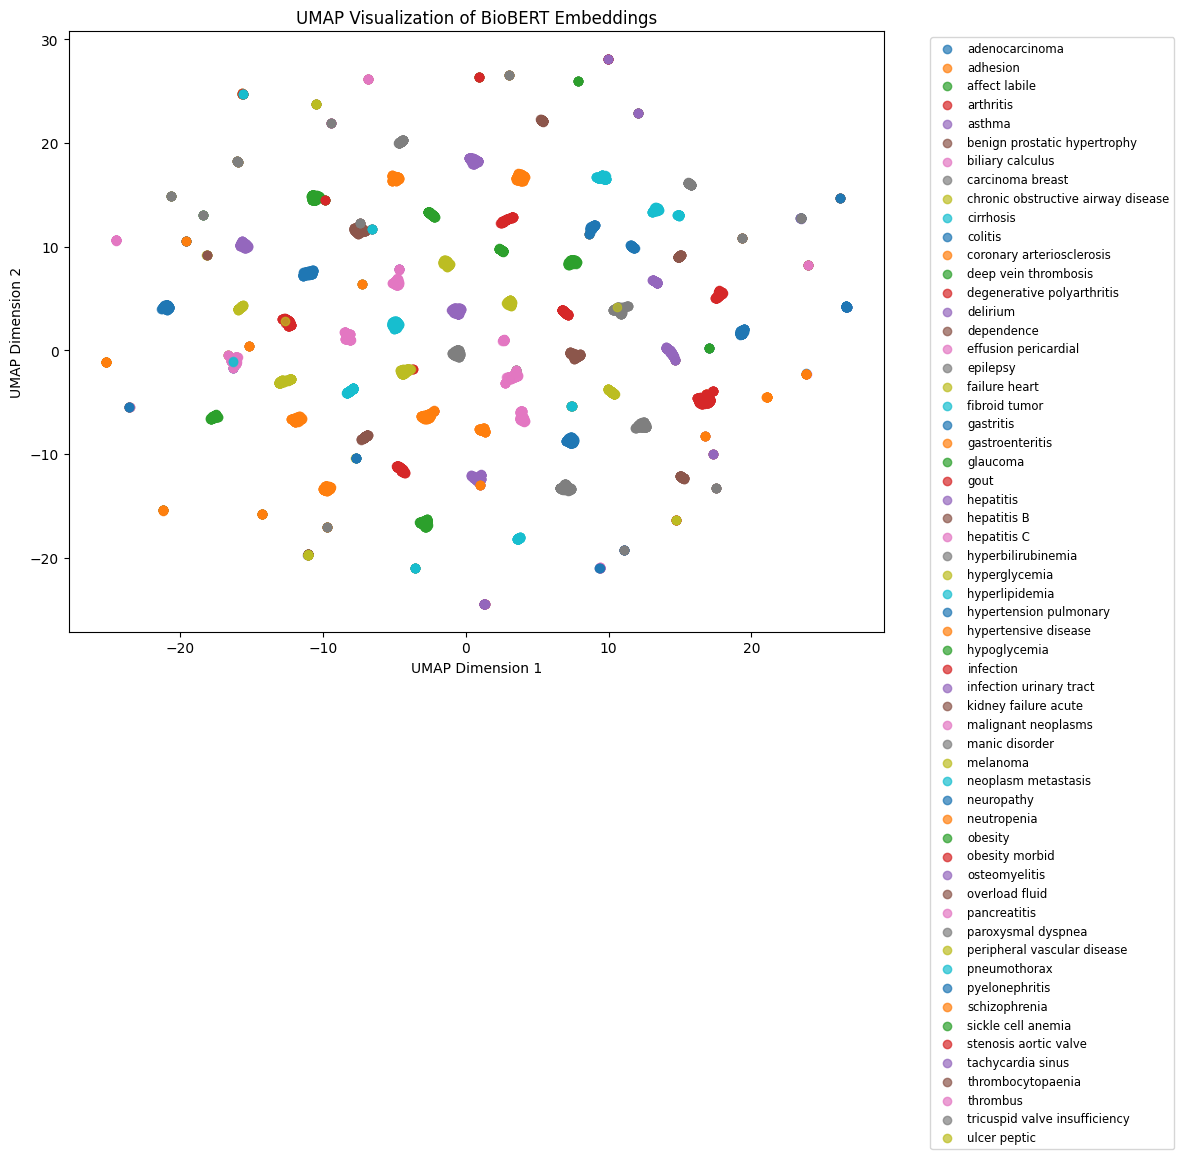

In [24]:
import umap.umap_ as umap
import matplotlib.pyplot as plt
import numpy as np

# Generate test embeddings (ensure this is executed before using UMAP)
# test_embeddings should already be generated using your generate_embeddings function.

# Convert test labels to NumPy for easier handling
labels = test_labels.cpu().numpy()  # Ensure this is defined and matches the test dataset

# Reduce dimensions using UMAP
print("Reducing dimensions using UMAP...")
umap_model = umap.UMAP(n_components=2, random_state=42)
reduced_embeddings = umap_model.fit_transform(test_embeddings)

# Map numeric labels to disease names
disease_names = label_encoder.inverse_transform(labels)  # Map numeric labels to actual disease names

# Plot the 2D representation
plt.figure(figsize=(12, 10))
unique_labels = np.unique(disease_names)

for disease in unique_labels:
    indices = np.where(disease_names == disease)
    plt.scatter(
        reduced_embeddings[indices, 0], reduced_embeddings[indices, 1],
        label=disease, alpha=0.7
    )

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.title("UMAP Visualization of BioBERT Embeddings")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.tight_layout()
plt.show()


# Naive Bayes

In [25]:
from sklearn.naive_bayes import GaussianNB
# Train Naive Bayes
nb_model = GaussianNB()
nb_model.fit(train_embeddings, train_data['encoded_labels'])

# Validate the Model
val_preds = nb_model.predict(val_embeddings)
val_report = classification_report(val_labels, val_preds, target_names=label_encoder.classes_, output_dict=True)
print("Validation Report:")
print(pd.DataFrame(val_report))

# Test the Model
test_preds = nb_model.predict(test_embeddings)
test_report = classification_report(test_labels, test_preds, target_names=label_encoder.classes_, output_dict=True)
print("Test Report:")
print(pd.DataFrame(test_report))

# Save Classification Report to CSV
test_report_df = pd.DataFrame(test_report).transpose()
test_report_path = "/content/drive/MyDrive/P2/T1/Dataset/combined/LLM+ML/biobert-nb-c-class.csv"
test_report_df.to_csv(test_report_path, index=True)
print(f"Classification report saved to {test_report_path}")

Validation Report:
           adenocarcinoma    adhesion  affect labile   arthritis     asthma  \
precision        1.000000    1.000000       1.000000    1.000000   0.897727   
recall           0.929825    0.970238       0.949367    0.938931   0.951807   
f1-score         0.963636    0.984894       0.974026    0.968504   0.923977   
support        171.000000  168.000000      79.000000  131.000000  83.000000   

           benign prostatic hypertrophy  biliary calculus  carcinoma breast  \
precision                      1.000000          0.912500          1.000000   
recall                         0.949367          0.752577          0.952941   
f1-score                       0.974026          0.824859          0.975904   
support                       79.000000        194.000000        170.000000   

           chronic obstructive airway disease   cirrhosis  ...  \
precision                            0.891156    1.000000  ...   
recall                               0.942446    0.947059

# Random Forest

In [26]:
# Train Random Forest on Embeddings
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(train_embeddings, train_data['encoded_labels'])

# Validate the Model
val_preds = rf_model.predict(val_embeddings)
val_report = classification_report(val_labels, val_preds, target_names=label_encoder.classes_, output_dict=True)
print("Validation Report:")
print(pd.DataFrame(val_report))

# Test the Model
test_preds = rf_model.predict(test_embeddings)
test_report = classification_report(test_labels, test_preds, target_names=label_encoder.classes_, output_dict=True)
print("Test Report:")
print(pd.DataFrame(test_report))


Validation Report:
           adenocarcinoma    adhesion  affect labile   arthritis     asthma  \
precision        0.976048    1.000000       1.000000    0.969466   0.949367   
recall           0.953216    0.976190       0.949367    0.969466   0.903614   
f1-score         0.964497    0.987952       0.974026    0.969466   0.925926   
support        171.000000  168.000000      79.000000  131.000000  83.000000   

           benign prostatic hypertrophy  biliary calculus  carcinoma breast  \
precision                      0.986842          0.967742          1.000000   
recall                         0.949367          0.773196          0.952941   
f1-score                       0.967742          0.859599          0.975904   
support                       79.000000        194.000000        170.000000   

           chronic obstructive airway disease   cirrhosis  ...  \
precision                            0.870968    1.000000  ...   
recall                               0.971223    0.947059

In [27]:
# Save Classification Report to CSV
test_report_df = pd.DataFrame(test_report).transpose()
test_report_path = "/content/drive/MyDrive/P2/T1/Dataset/combined/LLM+ML/biobert-rf-c-class.csv"
test_report_df.to_csv(test_report_path, index=True)
print(f"Classification report saved to {test_report_path}")

Classification report saved to /content/drive/MyDrive/P2/T1/Dataset/combined/LLM+ML/biobert-rf-c-class.csv


# Support Vector Classifier

In [28]:
# Train Support Vector Classifier (SVC) on Embeddings
from sklearn.svm import SVC

svc_model = SVC(kernel='linear', random_state=42)  # You can choose other kernels like 'rbf' or 'poly'
svc_model.fit(train_embeddings, train_data['encoded_labels'])

# Validate the Model
val_preds = svc_model.predict(val_embeddings)
val_report = classification_report(val_labels, val_preds, target_names=label_encoder.classes_, output_dict=True)
print("Validation Report:")
print(pd.DataFrame(val_report))

# Test the Model
test_preds = svc_model.predict(test_embeddings)
test_report = classification_report(test_labels, test_preds, target_names=label_encoder.classes_, output_dict=True)
print("Test Report:")
print(pd.DataFrame(test_report))


Validation Report:
           adenocarcinoma    adhesion  affect labile   arthritis     asthma  \
precision        0.954286    1.000000       1.000000    1.000000   1.000000   
recall           0.976608    0.976190       0.949367    0.938931   0.855422   
f1-score         0.965318    0.987952       0.974026    0.968504   0.922078   
support        171.000000  168.000000      79.000000  131.000000  83.000000   

           benign prostatic hypertrophy  biliary calculus  carcinoma breast  \
precision                      1.000000          0.993197          1.000000   
recall                         0.949367          0.752577          0.952941   
f1-score                       0.974026          0.856305          0.975904   
support                       79.000000        194.000000        170.000000   

           chronic obstructive airway disease   cirrhosis  ...  \
precision                            0.852761    1.000000  ...   
recall                               1.000000    0.947059

In [29]:
# Save Classification Report to CSV
test_report_df = pd.DataFrame(test_report).transpose()
test_report_path = "/content/drive/MyDrive/P2/T1/Dataset/combined/LLM+ML/biobert-svc-c-class.csv"
test_report_df.to_csv(test_report_path, index=True)
print(f"Classification report saved to {test_report_path}")

Classification report saved to /content/drive/MyDrive/P2/T1/Dataset/combined/LLM+ML/biobert-svc-c-class.csv
